In [2]:
!nvidia-smi

Tue Mar 23 22:52:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1D:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import sys
sys.path.append('../..')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
from tqdm import tqdm
from typing import Tuple, List
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob 
from dateutil import parser
import dateutil
import transformers
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
from scripts.get_train_test import normalize_target

## Подготовка данных 

In [6]:
def get_base_data():
    base_path = "../../data/Data DigitalFreud/final_data/"
    base_info_path = '1/item1.csv'

    base_info_file = os.path.join(base_path, base_info_path)
    base_info = pd.read_csv(base_info_file)
    base_info = base_info[(base_info.who_score.notna()) & (base_info.diener_score.notna())]
    return base_info

In [7]:
base_info = get_base_data()

In [8]:
base_info.who_score.max(), base_info.diener_score.max(), base_info.who_score.min(), base_info.diener_score.min()

(30.0, 35.0, 5.0, 5.0)

In [9]:
norm_data = normalize_target(base_info, "who_score", "diener_score")

In [10]:
#  попробовать нормализацию по пользователю (z-score)
norm_data

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,0.32,3.0,5.0,5.0,3.0,6.0,0.266667,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,0.44,6.0,2.0,1.0,2.0,5.0,0.466667,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,0.36,2.0,2.0,1.0,1.0,4.0,0.666667,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,0.40,5.0,5.0,5.0,5.0,5.0,0.166667,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,0.28,5.0,1.0,3.0,3.0,1.0,0.566667,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,0.44,5.0,5.0,1.0,5.0,4.0,0.333333,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,0.40,3.0,2.0,2.0,3.0,4.0,0.533333,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,0.20,5.0,2.0,2.0,5.0,5.0,0.366667,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,0.56,5.0,4.0,5.0,5.0,5.0,0.200000,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [11]:
norm_data = norm_data[norm_data["freud_install_time"].notna()]
norm_data

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,0.32,3.0,5.0,5.0,3.0,6.0,0.266667,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,0.44,6.0,2.0,1.0,2.0,5.0,0.466667,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,0.36,2.0,2.0,1.0,1.0,4.0,0.666667,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,0.40,5.0,5.0,5.0,5.0,5.0,0.166667,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,0.28,5.0,1.0,3.0,3.0,1.0,0.566667,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,0.44,5.0,5.0,1.0,5.0,4.0,0.333333,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,0.40,3.0,2.0,2.0,3.0,4.0,0.533333,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,0.20,5.0,2.0,2.0,5.0,5.0,0.366667,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,0.56,5.0,4.0,5.0,5.0,5.0,0.200000,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [12]:
norm_data["freud_install_time"] = pd.to_datetime(norm_data["freud_install_time"])

In [ ]:
# динамика установки приложения и прохождения теста

<AxesSubplot:xlabel='freud_install_time,freud_install_time'>

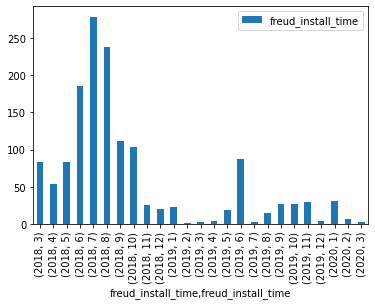

In [13]:
norm_data[["freud_install_time"]].groupby(
    [norm_data["freud_install_time"].dt.year, norm_data["freud_install_time"].dt.month]).count().\
plot(kind="bar")

<AxesSubplot:xlabel='freud_install_time'>

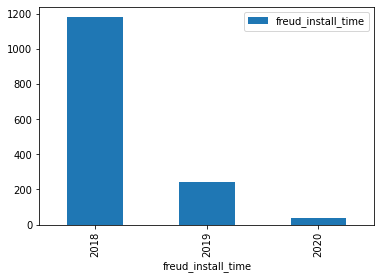

In [14]:
# вопросы не изменились ли 
norm_data[["freud_install_time"]].groupby(
    norm_data["freud_install_time"].dt.year).count().\
plot(kind="bar")

In [14]:
#norm_data = norm_data[norm_data["freud_install_time"].dt.year == 2018]

## Получаем тексты пользователей

In [15]:
files = glob("../../data/Data DigitalFreud/final_data/6/*")
files[:10]

['../../data/Data DigitalFreud/final_data/6/551455689.csv.gz',
 '../../data/Data DigitalFreud/final_data/6/620759360.csv.gz',
 '../../data/Data DigitalFreud/final_data/6/479302046.csv.gz',
 '../../data/Data DigitalFreud/final_data/6/825478329.csv.gz',
 '../../data/Data DigitalFreud/final_data/6/16637694.csv.gz',
 '../../data/Data DigitalFreud/final_data/6/262568788.csv.gz',
 '../../data/Data DigitalFreud/final_data/6/660475000.csv.gz',
 '../../data/Data DigitalFreud/final_data/6/520415673.csv.gz',
 '../../data/Data DigitalFreud/final_data/6/153806621.csv.gz',
 '../../data/Data DigitalFreud/final_data/6/418922171.csv.gz']

In [16]:
def get_user_texts(
    file, 
    add_post_text = False,
    id_field = "owner_id_encrypted",
    from_id_field = "from_id_encrypted",
    text_field = "text",
    text_post_field = "text_original",
    date_field = "date",

):

    def join_texts(x):
        "Обединяет ячейки с текстом пользователя к посту и текстом поста"
        user_text = x[text_field]
        repost_test = x[text_post_field]

        if not isinstance(user_text, str):
            user_text = ''

        if not isinstance(repost_test, str):
            repost_test = ''
        
        return str(user_text + ' ' + repost_test)
    
    with gzip.open(file, 'r') as f_in:
        original_texts = pd.read_csv(f_in)
    
    user_ids = original_texts[id_field].unique()
    
    if len(user_ids) != 1: 
        print('many user ids')
        
    user_id = user_ids[0]
    
    if not add_post_text:
    
        # filter by user origin id and check that post was written by this user
        filter_by_user = original_texts[
            (original_texts[id_field] == user_id) & 
            (original_texts[from_id_field] == user_id) &
            (original_texts.repost == False)
            
        ]
        needed_fields = filter_by_user[[date_field, id_field, text_field]]
        needed_fields = needed_fields.dropna()

        if needed_fields.empty:
            return None

        res = (
            user_id, 
            needed_fields[text_field].tolist(), 
            needed_fields[date_field].tolist()
        )

        assert len(res[1]) == len(res[2]), "len(dates)!=len(texts)"

        return res
    
    "По флагу добавляем тексты постов к тексту пользователя об этом посте"
    if add_post_text:
    
        # filter by user origin id and check that post was written by this user
        filter_by_user = original_texts[
            (original_texts[id_field] == user_id) & 
            (original_texts[from_id_field] == user_id)
            
        ]
        needed_fields = filter_by_user[[date_field, id_field, text_field, text_post_field]]
        
        if needed_fields.empty:
            return None
        
        needed_fields["join_texts"] = needed_fields.apply(join_texts, axis = 1)
        
        needed_fields = needed_fields[["join_texts", date_field, id_field]]
        needed_fields = needed_fields.dropna()

        if needed_fields.empty:
            return None
        
        filtred_texts, filtered_dates = [], []
        for text, date in zip(needed_fields["join_texts"].tolist(),  needed_fields[date_field].tolist()):
            if text != ' ':
                filtred_texts.append(text.replace('\n', ' '))
                filtered_dates.append(date)
        res = (
            user_id, 
            filtred_texts,
            filtered_dates
        )

        assert len(res[1]) == len(res[2]), "len(dates)!=len(texts)"

        return res

In [17]:
res = get_user_texts("../../data/Data DigitalFreud/final_data/6/825478329.csv.gz")

In [18]:
# попробовать: пользователи с одинаковыми интересами через кластеризацию на простых векторизаторах

In [19]:
import numpy as np

def get_text_post_filted_by_date(
    data,
    needed_users, 
    users_df_instalation_time,
    who_scores,
    diener_scores,
    files, 
    use_post_text=False, 
    period={"months": 6}
):

    f_texts, f_users, whos, dieners = [], [], [], []

    for file in tqdm(files):

        res = get_user_texts(file, use_post_text)

        if res is None:
            continue    

        user_id_, texts, dates = res

        for user_id, time, who, diener in zip(
            data[needed_users].tolist(), 
            data[users_df_instalation_time].tolist(),
            data[who_scores].tolist(),
            data[diener_scores].tolist()
        ): 

            if user_id == user_id_:
                right_boundary = parser.parse(str(time))
                left_boundary = right_boundary - dateutil.relativedelta.relativedelta(**period)


                texts_filtered_by_dates = []
                for text, date in zip(texts, dates):
                    if left_boundary <= parser.parse(date) <= right_boundary:
                        texts_filtered_by_dates.append((text, date))

                f_texts.append(
                    tuple(texts_filtered_by_dates) if texts_filtered_by_dates else np.NaN
                )
                f_users.append(user_id)
                whos.append(who)
                dieners.append(diener)
                    

    join_data = pd.DataFrame(
        {"texts": f_texts, "users": f_users, "who_score": whos, "diener_score": dieners}
    )
    #join_data = join_data.dropna()
    return join_data

In [1]:
# получаем тексты всех постов за 10 лет

In [20]:

norm_data_texts = get_text_post_filted_by_date(
    norm_data, "vk_id_encrypted", "freud_install_time", "who_score", "diener_score", files,
    period={"months": 120}
)

100%|██████████| 1874/1874 [01:05<00:00, 28.78it/s]


In [21]:
norm_data_texts

,texts,users,who_score,diener_score
0,"((Закат 02.12, 2016-12-02 15:28:43), (Что вы з...",620759360,0.48,0.200000
1,"((Крепись Филимон✊, 2018-07-07 15:45:49), (Thi...",16637694,0.44,0.233333
2,NaN,262568788,0.36,0.666667
3,"((-спокойной ночи,добрый князь\n-спокойной ноч...",660475000,0.12,0.400000
4,((Всех с прошедшим))))ссори что не смогла позд...,520415673,0.64,0.366667
...,...,...,...,...
1108,"((Снежный петушок и я, 2017-01-04 18:13:00), (...",843618346,0.32,0.600000
1109,"((📷🎞, 2018-01-27 20:55:31),)",878862664,0.76,0.933333
1110,NaN,202020680,0.04,0.000000
1111,NaN,202020680,0.04,0.000000


In [22]:
norm_data_texts = norm_data_texts.drop_duplicates()
norm_data_texts

,texts,users,who_score,diener_score
0,"((Закат 02.12, 2016-12-02 15:28:43), (Что вы з...",620759360,0.48,0.200000
1,"((Крепись Филимон✊, 2018-07-07 15:45:49), (Thi...",16637694,0.44,0.233333
2,NaN,262568788,0.36,0.666667
3,"((-спокойной ночи,добрый князь\n-спокойной ноч...",660475000,0.12,0.400000
4,((Всех с прошедшим))))ссори что не смогла позд...,520415673,0.64,0.366667
...,...,...,...,...
1106,((Люблю этот город. Очень приятно наблюдать го...,235794648,0.52,0.400000
1107,((love is a name.sex is a game.forget the name...,843617164,0.40,0.466667
1108,"((Снежный петушок и я, 2017-01-04 18:13:00), (...",843618346,0.32,0.600000
1109,"((📷🎞, 2018-01-27 20:55:31),)",878862664,0.76,0.933333


In [25]:
norm_data_texts[norm_data_texts.texts.isna()]

,texts,users,who_score,diener_score
0,NaN,262568788,0.36,0.666667
6,NaN,979859193,0.40,0.500000
11,NaN,674724055,0.56,0.200000
15,NaN,518139635,0.52,0.333333
20,NaN,450934237,0.44,0.500000
...,...,...,...,...
873,NaN,132763617,0.76,0.600000
876,NaN,974673320,0.64,0.633333
877,NaN,72464951,0.44,0.666667
878,NaN,951321949,0.68,0.200000


In [ ]:
# Проверим отличаются ли распределения таргетов у пользователей без постов от пользователей с поставми? 
# Ответ - нет, значит нельзя использовать как фичу  

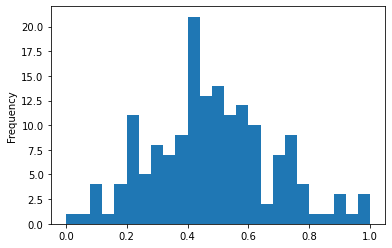

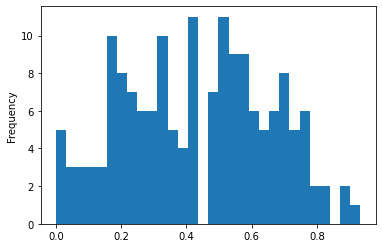

In [26]:
import matplotlib.pyplot as plt
norm_data_texts[norm_data_texts.texts.isna()].who_score.plot.hist(bins=25)
plt.show()
norm_data_texts[norm_data_texts.texts.isna()].diener_score.plot.hist(bins=30)
plt.show()

In [23]:
data_with_text = norm_data_texts[norm_data_texts.texts.notna()]

In [24]:
data_with_text

,texts,users,who_score,diener_score
0,"((Закат 02.12, 2016-12-02 15:28:43), (Что вы з...",620759360,0.48,0.200000
1,"((Крепись Филимон✊, 2018-07-07 15:45:49), (Thi...",16637694,0.44,0.233333
3,"((-спокойной ночи,добрый князь\n-спокойной ноч...",660475000,0.12,0.400000
4,((Всех с прошедшим))))ссори что не смогла позд...,520415673,0.64,0.366667
5,((у кого что случилось в эту новогоднюю ночь: ...,418922171,0.56,0.733333
...,...,...,...,...
1105,"((Всех с масленицей!!!!, 2016-03-07 11:23:29),...",62730161,0.52,0.333333
1106,((Люблю этот город. Очень приятно наблюдать го...,235794648,0.52,0.400000
1107,((love is a name.sex is a game.forget the name...,843617164,0.40,0.466667
1108,"((Снежный петушок и я, 2017-01-04 18:13:00), (...",843618346,0.32,0.600000


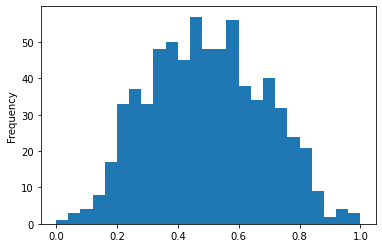

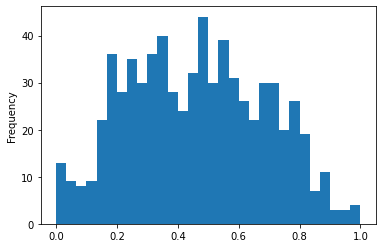

In [29]:
data_with_text.who_score.plot.hist(bins=25)
plt.show()
data_with_text.diener_score.plot.hist(bins=30)
plt.show()

In [2]:
# есть ли корреляция между количеством постов написанных за последние три месяца и таргетом? Ответ - нет

In [25]:
data_with_text["n_texts"] = data_with_text["texts"].apply(lambda x:len(x))

<ipython-input-25-12ccb57e3292>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_text["n_texts"] = data_with_text["texts"].apply(lambda x:len(x))


In [26]:
data_with_text[data_with_text["n_texts"]==2]

,texts,users,who_score,diener_score,n_texts
19,"((— Ненавижу бордовый цвет, — то ли в шутку, т...",999546489,0.32,0.200000,2
22,"((ᅠᅠᅠᅠ\nᅠᅠᅠᅠя ― эмоционально выжат, растоптан,...",797759937,0.32,0.233333,2
46,"((Немного о вчера, 2018-06-14 08:30:56), (Эта ...",186801771,0.56,0.400000,2
62,"((""Я не люблю, когда мне лезут в душу.\nТем бо...",305836538,0.20,0.333333,2
66,"((#ИнФОждётчуда, 2018-12-18 04:35:24), (Где-то...",984448986,0.68,0.766667,2
...,...,...,...,...,...
1062,"((Девиз: «Кто владеет информацией, тот владеет...",348227490,0.64,0.800000,2
1089,"((...Видели ли вы, как дочь Билли Грэма участв...",17444908,0.56,0.233333,2
1092,"((мне без тебя здесь мир не победить., 2018-01...",934579595,0.32,0.300000,2
1093,"((#осеннийсплин, 2016-09-24 07:27:28), (Мы буд...",378329172,0.68,0.766667,2


In [3]:
# who_score

In [27]:
data_with_text["n_texts"].corr(data_with_text["who_score"])

0.03570049162662011

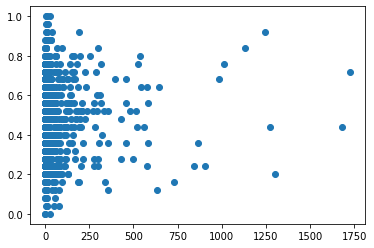

In [28]:
plt.scatter(data_with_text["n_texts"], data_with_text["who_score"])

In [ ]:
# diener_score

In [30]:
data_with_text["n_texts"].corr(data_with_text["diener_score"])

0.04568398931887468

<AxesSubplot:ylabel='Frequency'>

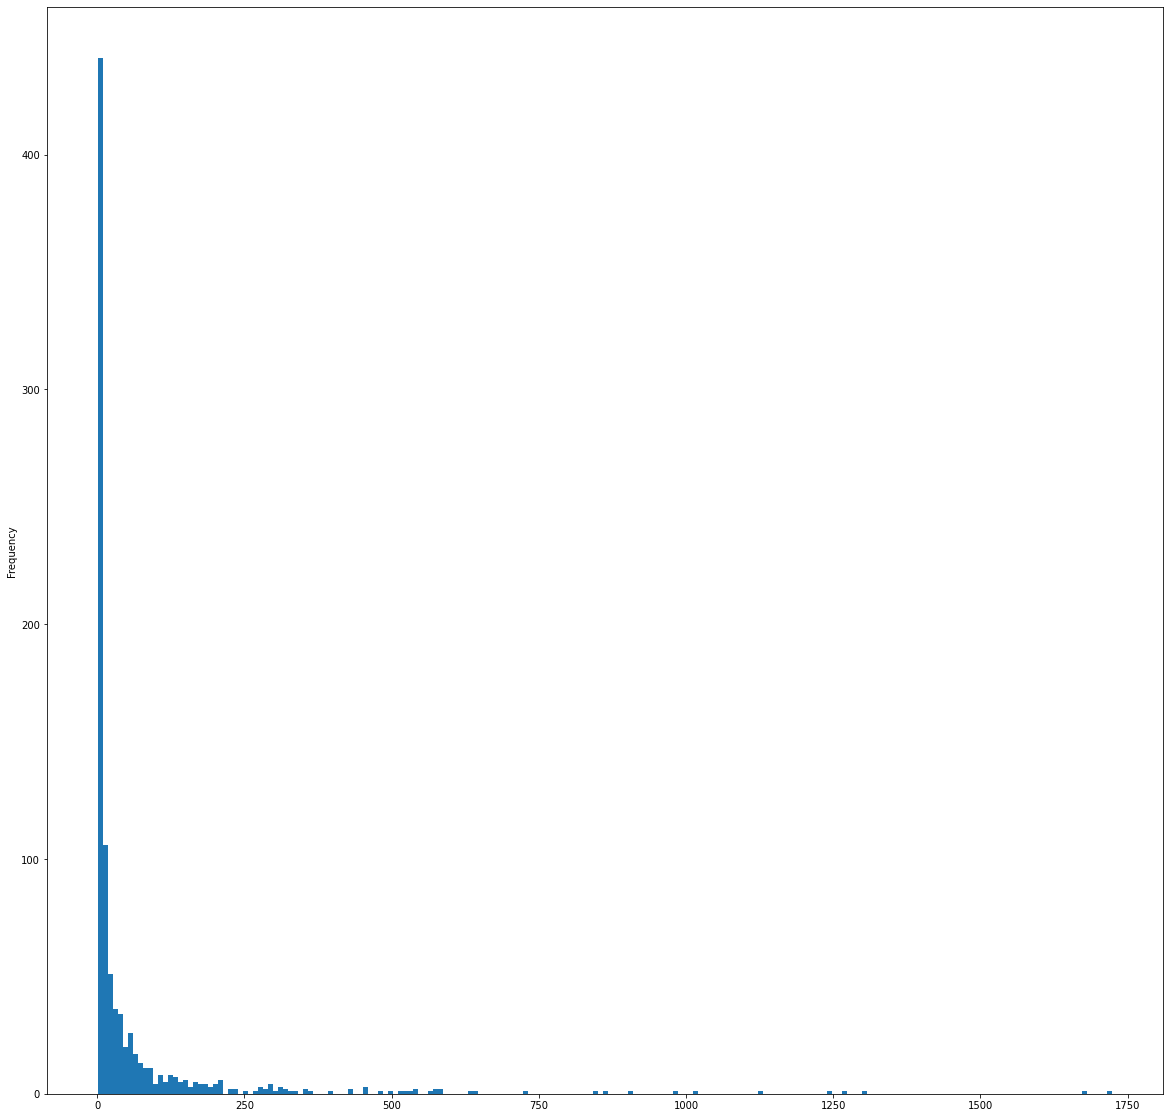

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
data_with_text["n_texts"].plot.hist(bins=len(data_with_text["n_texts"].unique()))


In [ ]:
# Предположим, что до трех постов за три месяца нам ни о чем не говорит, 
# а боллее 250 - это блогеры, обрежем распределение и поищем корреляцию у "простых людей"

(595, 5)

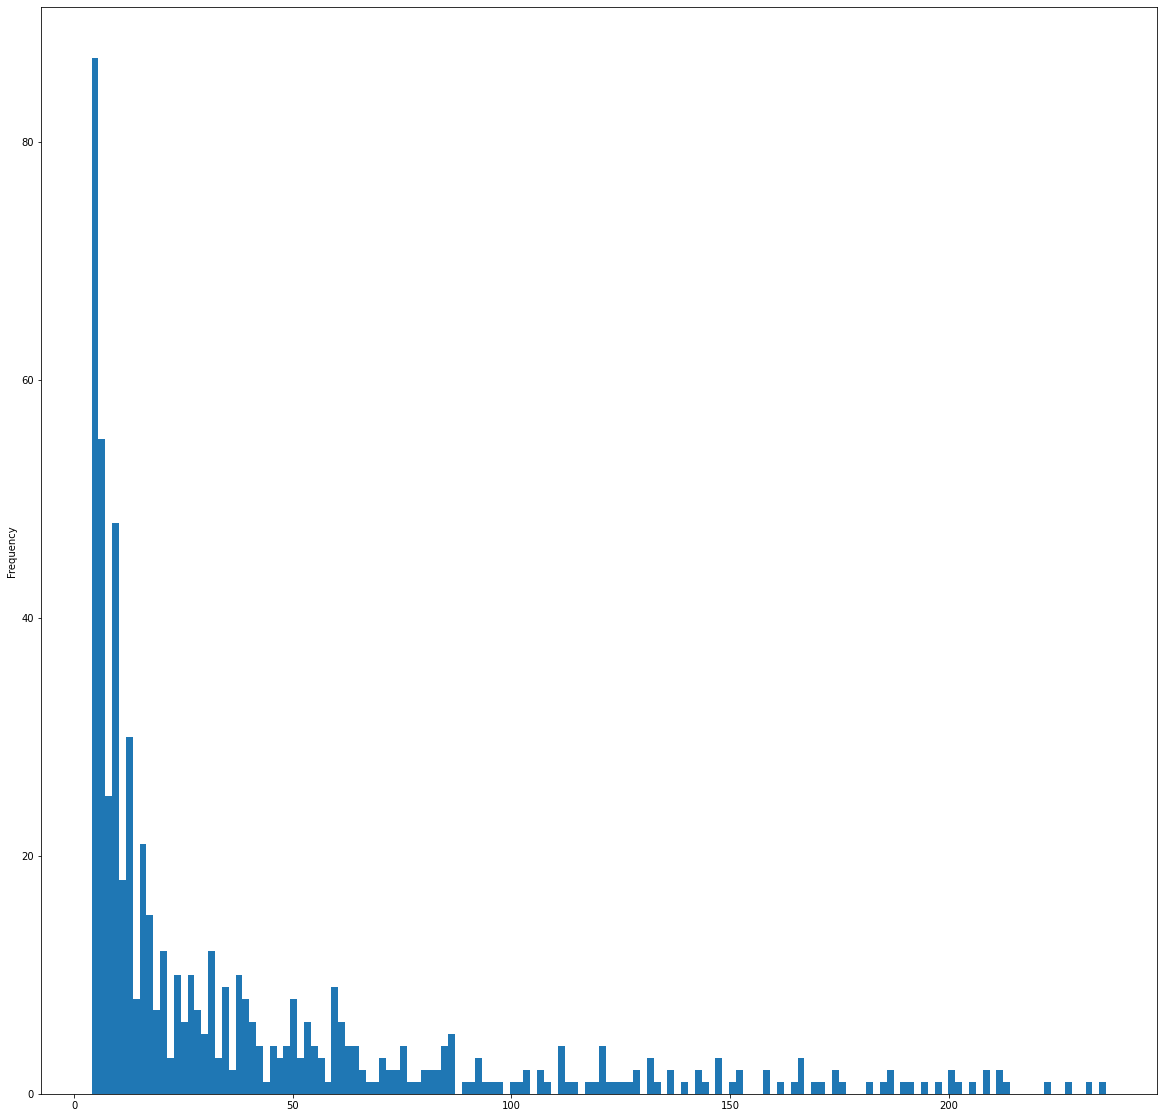

In [32]:
#log and no right bound
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
slice_=  data_with_text[(data_with_text["n_texts"]>3) & (data_with_text["n_texts"]<250)]
slice_["n_texts"].plot.hist(bins=len(slice_["n_texts"].unique()))
slice_.shape

In [38]:
slice_["n_texts"].corr(slice_["who_score"]), slice_["n_texts"].corr(slice_["diener_score"]) 

(0.007802091658203979, 0.0603610022527842)

In [ ]:
# подготовим данные и проверим может быть есть корреляции между 
# количеством постом за один/два/три... года до установки приложения и таргетом

In [39]:
slice_[2:3].texts.values.tolist()[0]

(('С ДНЁМ РОЖДЕНИЯ, ХЛоПУШКА!!! 💙', '2015-09-10 07:15:30'),
 ('даже не тянет', '2015-10-03 11:55:42'),
 ('Привет Уэсу Андерсрну из Динхая!', '2016-10-29 14:03:44'),
 ('Ода динхаю!', '2016-11-12 11:25:40'),
 ("I‘m so HAPPY 'cause today", '2016-11-24 08:31:58'),
 ('Все грибы размножаются спорами. \nВ спорах рождается истина. \n_____________________________________\nСледовательно, истина рождается благодаря грибам.',
  '2016-12-24 09:42:04'),
 ('Would you rather be a fish?', '2017-02-26 18:31:49'),
 ('Вчера с Алиной закрыли ноябрь!✋😆🎉', '2017-12-01 11:54:34'))

In [40]:
i = 5
sample = slice_[i:i+1].texts.values.tolist()[0]

In [41]:
sample_df = pd.DataFrame({"text":[j for j,i in sample], "data":[pd.Timestamp(i) for j,i in sample]})

<AxesSubplot:xlabel='data'>

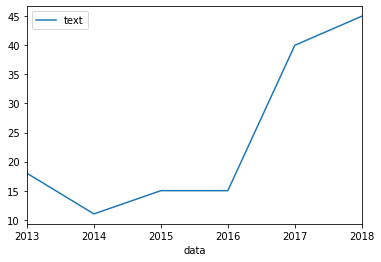

In [42]:
sample_df.groupby(pd.Grouper(key="data", freq="1Y")).count().plot()

In [43]:
sample_df.groupby(pd.Grouper(key="data", freq="1Y")).count().to_dict()

{'text': {Timestamp('2013-12-31 00:00:00', freq='A-DEC'): 18,
  Timestamp('2014-12-31 00:00:00', freq='A-DEC'): 11,
  Timestamp('2015-12-31 00:00:00', freq='A-DEC'): 15,
  Timestamp('2016-12-31 00:00:00', freq='A-DEC'): 15,
  Timestamp('2017-12-31 00:00:00', freq='A-DEC'): 40,
  Timestamp('2018-12-31 00:00:00', freq='A-DEC'): 45}}

In [44]:
def distribution_over_time(sample):
    years = {pd.Timestamp(f'201{i}-12-31 00:00:00'):0 for i in range(10)}
    sample_df = pd.DataFrame(
        {"text":[j for j,i in sample], "data":[pd.Timestamp(i) for j,i in sample]}
    )
    data_dict = sample_df.groupby(pd.Grouper(key="data", freq="1Y")).count().to_dict()
    for time_step, value in data_dict["text"].items():
        years[time_step] = value
    return years.values()
    

In [45]:
slice_["distribution_over_time"] = slice_["texts"].apply(distribution_over_time)

<ipython-input-45-3f0853f29e8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_["distribution_over_time"] = slice_["texts"].apply(distribution_over_time)


In [46]:
slice_["distribution_over_time"]

3         (0, 8, 1, 3, 7, 4, 1, 0, 0, 0)
4       (0, 0, 0, 0, 0, 0, 88, 42, 7, 0)
7         (0, 0, 0, 0, 0, 2, 4, 2, 0, 0)
8      (0, 0, 0, 0, 0, 19, 89, 19, 2, 0)
9        (0, 0, 0, 2, 16, 7, 6, 6, 1, 0)
                     ...                
875       (0, 0, 0, 0, 0, 0, 6, 1, 2, 0)
879       (0, 0, 0, 0, 0, 0, 8, 2, 2, 0)
880      (0, 0, 0, 0, 0, 0, 5, 15, 7, 0)
881     (78, 7, 0, 6, 16, 0, 0, 0, 0, 0)
882       (0, 0, 0, 0, 0, 0, 0, 3, 1, 0)
Name: distribution_over_time, Length: 459, dtype: object

In [47]:
to_many_columns = lambda x: pd.Series([i for i in x])
distribution_over_time_slice_ = slice_["distribution_over_time"].apply(to_many_columns)

In [48]:
distribution_over_time_slice_ = pd.concat([distribution_over_time_slice_, slice_], axis=1)

In [49]:
distribution_over_time_slice_

,0,1,2,3,4,5,6,7,8,9,10,11,texts,users,who_score,diener_score,n_texts,distribution_over_time
3,0.0,8.0,1.0,3.0,7.0,4.0,1.0,0.0,0.0,0.0,NaN,NaN,((у кого что случилось в эту новогоднюю ночь: ...,418922171,0.56,0.733333,24,"(0, 8, 1, 3, 7, 4, 1, 0, 0, 0)"
4,0.0,0.0,0.0,0.0,0.0,0.0,88.0,42.0,7.0,0.0,NaN,NaN,((Новогодняя ночь на работе с любимым 💜👑🎄 #31....,186157818,0.52,0.466667,137,"(0, 0, 0, 0, 0, 0, 88, 42, 7, 0)"
7,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,0.0,0.0,NaN,NaN,"((С ДНЁМ РОЖДЕНИЯ, ХЛоПУШКА!!! 💙, 2015-09-10 0...",970432758,0.40,0.333333,8,"(0, 0, 0, 0, 0, 2, 4, 2, 0, 0)"
8,0.0,0.0,0.0,0.0,0.0,19.0,89.0,19.0,2.0,0.0,NaN,NaN,"((I'm ballin' outta control, I'm ballin' outta...",130803750,0.20,0.300000,129,"(0, 0, 0, 0, 0, 19, 89, 19, 2, 0)"
9,0.0,0.0,0.0,2.0,16.0,7.0,6.0,6.0,1.0,0.0,NaN,NaN,"((прикольна, 2013-11-02 16:55:25), (поздравляю...",741269384,0.48,0.366667,38,"(0, 0, 0, 2, 16, 7, 6, 6, 1, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,0.0,NaN,NaN,"((Vsauce: Послания в будущее, 2016-01-06 21:33...",414097907,0.44,0.166667,9,"(0, 0, 0, 0, 0, 0, 6, 1, 2, 0)"
879,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,2.0,0.0,NaN,NaN,"((Всех с масленицей!!!!, 2016-03-07 11:23:29),...",62730161,0.52,0.333333,12,"(0, 0, 0, 0, 0, 0, 8, 2, 2, 0)"
880,0.0,0.0,0.0,0.0,0.0,0.0,5.0,15.0,7.0,0.0,NaN,NaN,((Люблю этот город. Очень приятно наблюдать го...,235794648,0.52,0.400000,27,"(0, 0, 0, 0, 0, 0, 5, 15, 7, 0)"
881,78.0,7.0,0.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,((love is a name.sex is a game.forget the name...,843617164,0.40,0.466667,107,"(78, 7, 0, 6, 16, 0, 0, 0, 0, 0)"


In [53]:
for i in range(10):
    print(f"Count of user post in {2008 + i} year")
    print(
        f"who_score corr: {distribution_over_time_slice_[i].corr(distribution_over_time_slice_['who_score'])}", 
        f"diener_score corr: {distribution_over_time_slice_[i].corr(distribution_over_time_slice_['diener_score'])}" 
    )


Count of user post in 2008 year
who_score corr: 0.017836684915232204 diener_score corr: 0.025148021360022896
Count of user post in 2009 year
who_score corr: 0.03554567063460767 diener_score corr: -0.006896397960276768
Count of user post in 2010 year
who_score corr: 0.07961299718095502 diener_score corr: -0.028898219896566397
Count of user post in 2011 year
who_score corr: 0.01683760026439544 diener_score corr: 0.03116128610646463
Count of user post in 2012 year
who_score corr: -0.03622150182219004 diener_score corr: 0.054976100726882825
Count of user post in 2013 year
who_score corr: -0.06137935415425206 diener_score corr: 0.0025401000826672467
Count of user post in 2014 year
who_score corr: -0.04939095507258903 diener_score corr: 0.041051722694944746
Count of user post in 2015 year
who_score corr: 0.05349539460221818 diener_score corr: 0.10695764380911617
Count of user post in 2016 year
who_score corr: 0.009090359106843547 diener_score corr: -0.01828924465318184
Count of user post in 

In [56]:
distribution_over_time_slice_[range(10)]

,0,1,2,3,4,5,6,7,8,9
3,0.0,8.0,1.0,3.0,7.0,4.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,88.0,42.0,7.0,0.0
7,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,19.0,89.0,19.0,2.0,0.0
9,0.0,0.0,0.0,2.0,16.0,7.0,6.0,6.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
875,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,0.0
879,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,2.0,0.0
880,0.0,0.0,0.0,0.0,0.0,0.0,5.0,15.0,7.0,0.0
881,78.0,7.0,0.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# визуализируем расположение данных в матрице и поймем, что в большей части нашей выборки люди стали писать посты только в 16-18 годах, 
# а корреляции между частотами в этот преиод и тергетом нет, гипотеза проверена

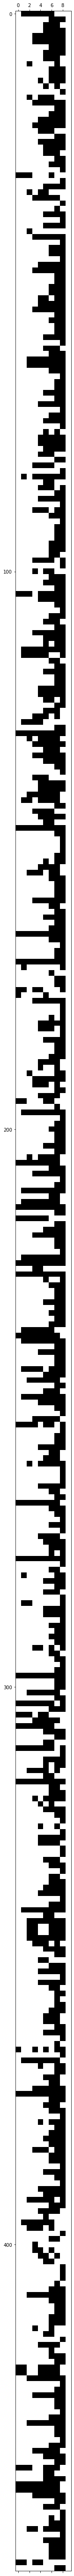

In [64]:
plt.figure(figsize=(100,100))

plt.spy(distribution_over_time_slice_[range(10)].values)

# Подготовка данных для берт-моделей

In [78]:
norm_data

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,0.32,3.0,5.0,5.0,3.0,6.0,0.266667,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,0.44,6.0,2.0,1.0,2.0,5.0,0.466667,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,0.36,2.0,2.0,1.0,1.0,4.0,0.666667,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,0.40,5.0,5.0,5.0,5.0,5.0,0.166667,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,0.28,5.0,1.0,3.0,3.0,1.0,0.566667,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,0.44,5.0,5.0,1.0,5.0,4.0,0.333333,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,0.40,3.0,2.0,2.0,3.0,4.0,0.533333,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,0.20,5.0,2.0,2.0,5.0,5.0,0.366667,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,0.56,5.0,4.0,5.0,5.0,5.0,0.200000,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [6]:
# Отсеиваем пользоватлей у которых есть меньше чем два поста за 10 лет, как семплы с недостаточным описанием
# Почему кажется валидным оставить 10 лет? 
# Матрица частот (визуализированная выше) показывает, что данные появлются только ближе ко времени установки приложения
# Эти данные могут создать шум, однако таким образом мы выиграем по размеру выборки и к тому же в Берте есть positional encoding, 
# который может выучить зависимость между положением поста (чем правее тем релевантнее) и таргетом

In [33]:
data_with_many_text =data_with_text[data_with_text.n_texts > 2]
data_with_many_text

,texts,users,who_score,diener_score,n_texts
0,"((Закат 02.12, 2016-12-02 15:28:43), (Что вы з...",620759360,0.48,0.200000,8
1,"((Крепись Филимон✊, 2018-07-07 15:45:49), (Thi...",16637694,0.44,0.233333,5
3,"((-спокойной ночи,добрый князь\n-спокойной ноч...",660475000,0.12,0.400000,358
4,((Всех с прошедшим))))ссори что не смогла позд...,520415673,0.64,0.366667,644
5,((у кого что случилось в эту новогоднюю ночь: ...,418922171,0.56,0.733333,24
...,...,...,...,...,...
1101,"((Vsauce: Послания в будущее, 2016-01-06 21:33...",414097907,0.44,0.166667,9
1105,"((Всех с масленицей!!!!, 2016-03-07 11:23:29),...",62730161,0.52,0.333333,12
1106,((Люблю этот город. Очень приятно наблюдать го...,235794648,0.52,0.400000,27
1107,((love is a name.sex is a game.forget the name...,843617164,0.40,0.466667,107


In [4]:
# Diener score

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_with_many_text.texts, data_with_many_text.diener_score)

In [35]:
X_train

316     ((Стрижка, окрашивание с растяжкой цвета(Indol...
811     ((он сказал: 'было бы здорово, если бы мы прос...
270     ((Знаете, друзья, со временем многое понимаешь...
687     ((Счастливее меня в мире нет))), 2015-12-07 14...
1081    ((#засветились #фотостудиякадр #фотодлясеминар...
                              ...                        
904     ((⚡, 2018-02-06 22:15:23), (GR8👑, 2018-02-21 2...
384     ((Продолжаю любить своих девчат, как бы долго ...
568     ((extinguish, 2017-07-16 17:01:48), (Когда соз...
374     ((Вот и настал долгожданный 2018 год хочу позд...
1050    ((Смотрите "Черданцев. Расширенная версия" на ...
Name: texts, Length: 521, dtype: object

In [36]:
def get_text(x):
    
    text = " ".join([j[0] for j in x])
    return text.replace("\n", ' ')

X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)

In [37]:
X_test_join

745    всех с прошедшим праздником! Пусть 2010 год пр...
4      Всех с прошедшим))))ссори что не смогла поздра...
691    Я нашел бесплатное приложение для создания кру...
228    30 привычек, от которых необходимо отказаться ...
109    "Don`t worry baby, don`t you cry, As long as w...
                             ...                        
188    MANDARINKI - ИДИ ТЫ НАХЕР (2011) A21 Records p...
947    мда...уже первая песня показывает всю колхозно...
985    -у нас был секс, мне было грустно... -грустно,...
300    Ребята из 1й и 2й групп, приезжайте ко второй ...
201    Brian Culbertson "On My Mind" Live at Java Jaz...
Name: texts, Length: 174, dtype: object

In [38]:
train_texts = pd.DataFrame({"join_text": X_train_join.tolist(),  "diener_score": y_train.tolist()})
test_texts = pd.DataFrame({"join_text": X_test_join.tolist(),  "diener_score": y_test.tolist()})

In [39]:
train_texts

,join_text,diener_score
0,"Стрижка, окрашивание с растяжкой цвета(Indola)...",0.366667
1,"он сказал: 'было бы здорово, если бы мы просто...",0.200000
2,"Знаете, друзья, со временем многое понимаешь.....",0.200000
3,Счастливее меня в мире нет))) Под самым красив...,0.333333
4,#засветились #фотостудиякадр #фотодлясеминара ...,0.400000
...,...,...
516,"⚡ GR8👑 Жить в эпоху свершений, имея возвышенны...",0.433333
517,"Продолжаю любить своих девчат, как бы долго их...",0.733333
518,extinguish Когда создаёшь персонажа: когда кто...,0.533333
519,Вот и настал долгожданный 2018 год хочу поздра...,0.700000


In [40]:
from scripts.bert_trainer import train_bert

In [ ]:
# убедимся что распределния на трейнеи на тесте похожы

<AxesSubplot:>

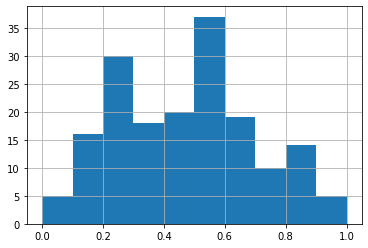

In [41]:
test_texts.diener_score.hist()

<AxesSubplot:>

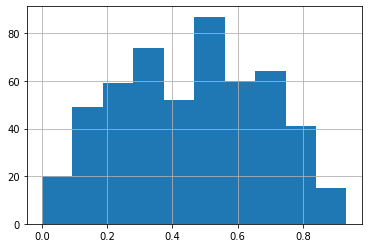

In [43]:
train_texts.diener_score.hist()

In [ ]:
# bert base multilingual and diener_score

100%|██████████| 174/174 [00:12<00:00, 14.36it/s]
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertMSE: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertMSE from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertMSE from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertMSE were not initialized from the model checkpoint at bert-base-multilingual-cas


======== Epoch 0 / 3 ========
Training...


Epoch 0: 100%|██████████| 33/33 [00:16<00:00,  1.97batch/s, loss=0.0393]



  Average valid loss: 0.06
Report:
mean_squared_error: 0.057788729667663574
mean_absolute_error: 0.20034320652484894
r2_score -0.09032337524245482
pearsonr_corr: -0.01750887636133802, pearsonr_p: 0.8186273367905275



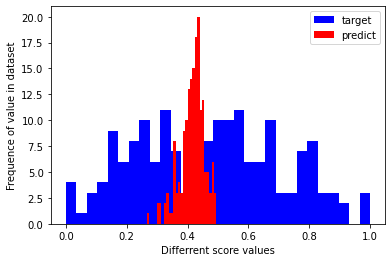

Epoch 1:   0%|          | 0/33 [00:00<?, ?batch/s]

  Validation took: 0:00:02

======== Epoch 1 / 3 ========
Training...


Epoch 1: 100%|██████████| 33/33 [00:16<00:00,  1.98batch/s, loss=0.0764]



  Average valid loss: 0.06
Report:
mean_squared_error: 0.05564137548208237
mean_absolute_error: 0.19726422429084778
r2_score -0.04980834604580231
pearsonr_corr: 0.07260110473330601, pearsonr_p: 0.3410824313680126



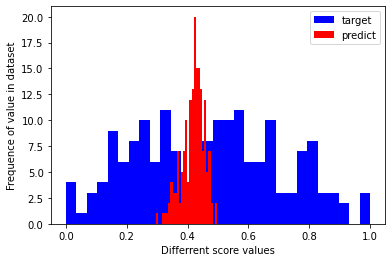

Epoch 2:   0%|          | 0/33 [00:00<?, ?batch/s]

  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...


Epoch 2: 100%|██████████| 33/33 [00:16<00:00,  1.98batch/s, loss=0.077] 



  Average valid loss: 0.06
Report:
mean_squared_error: 0.05604448541998863
mean_absolute_error: 0.1978824883699417
r2_score -0.057413963349871366
pearsonr_corr: 0.08657902050929109, pearsonr_p: 0.25597393538154295



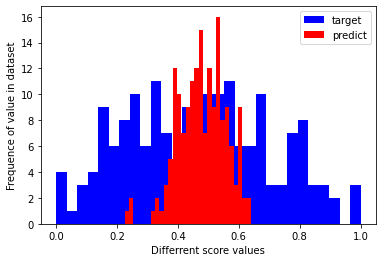

  Validation took: 0:00:02

Training complete!


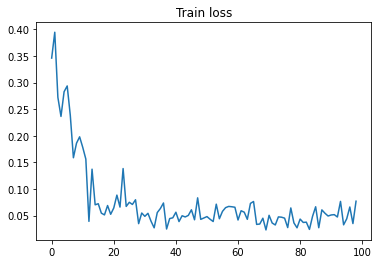

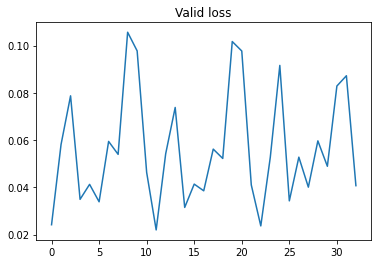

In [42]:
m_mert = train_bert(
    train=train_texts,
    test=test_texts,
    target="diener_score",
    source="join_text",
    epochs=3
)

In [ ]:
# bert base multilingual and who score

100%|██████████| 174/174 [00:06<00:00, 26.24it/s]
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertMSE: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertMSE from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertMSE from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertMSE were not initialized from the model checkpoint at bert-base-multilingual-cas


======== Epoch 0 / 3 ========
Training...


Epoch 0: 100%|██████████| 33/33 [00:16<00:00,  1.98batch/s, loss=0.0239]



  Average valid loss: 0.04
Report:
mean_squared_error: 0.04430000111460686
mean_absolute_error: 0.17180000245571136
r2_score -0.137
pearsonr_corr: -0.0952, pearsonr_p: 0.2113
spearman_corr: -0.0422, spearman_p: 0.5808



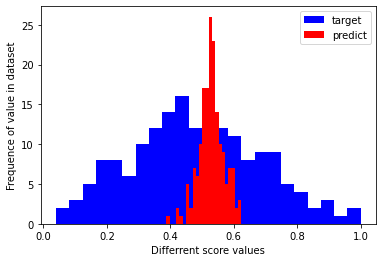

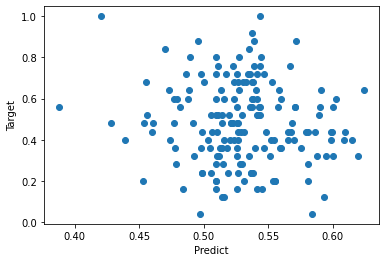

Epoch 1:   0%|          | 0/33 [00:00<?, ?batch/s]

  Validation took: 0:00:02

======== Epoch 1 / 3 ========
Training...


Epoch 1: 100%|██████████| 33/33 [00:16<00:00,  1.99batch/s, loss=0.0692]



  Average valid loss: 0.04
Report:
mean_squared_error: 0.04039999842643738
mean_absolute_error: 0.16500000655651093
r2_score -0.0388
pearsonr_corr: 0.0763, pearsonr_p: 0.3167
spearman_corr: 0.1409, spearman_p: 0.0636



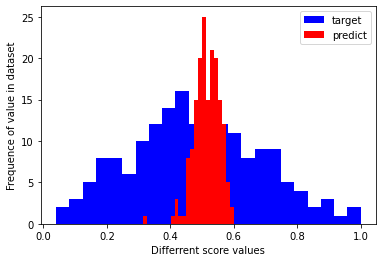

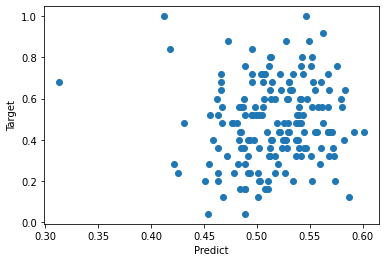

Epoch 2:   0%|          | 0/33 [00:00<?, ?batch/s]

  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...


Epoch 2: 100%|██████████| 33/33 [00:16<00:00,  1.98batch/s, loss=0.0155]



  Average valid loss: 0.04
Report:
mean_squared_error: 0.04100000113248825
mean_absolute_error: 0.16670000553131104
r2_score -0.0543
pearsonr_corr: 0.0655, pearsonr_p: 0.3904
spearman_corr: 0.119, spearman_p: 0.1177



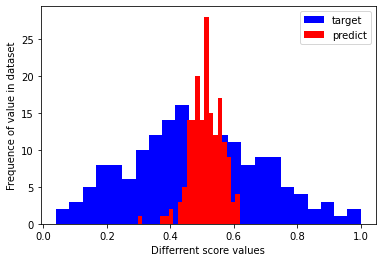

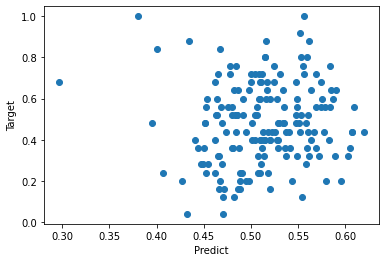

  Validation took: 0:00:02

Training complete!


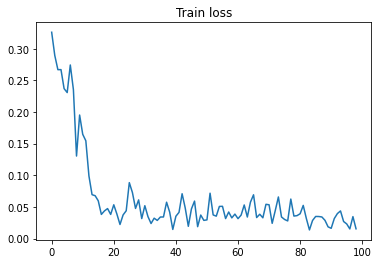

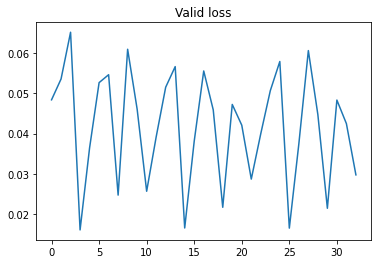

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_with_many_text.texts, data_with_many_text.who_score)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)
train_texts = pd.DataFrame({"join_text": X_train_join.tolist(),  "who_score": y_train.tolist()})
test_texts = pd.DataFrame({"join_text": X_test_join.tolist(),  "who_score": y_test.tolist()})
m_mert = train_bert(
    train=train_texts,
    test=test_texts,
    target="who_score",
    source="join_text",
    epochs=3
)

In [7]:
# sentence_ru_cased_L-12_H-768_A-12_pt and diener_score

100%|██████████| 174/174 [00:06<00:00, 25.56it/s]
Some weights of the model checkpoint at /home/ssorokin/sentence_ru_cased_L-12_H-768_A-12_pt/ were not used when initializing BertMSE: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertMSE from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertMSE from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertMSE were not initialized from the model checkpoint at /h


======== Epoch 0 / 3 ========
Training...


Epoch 0: 100%|██████████| 33/33 [00:16<00:00,  1.99batch/s, loss=0.0306]



  Average valid loss: 0.05
Report:
mean_squared_error: 0.05000000074505806
mean_absolute_error: 0.18299999833106995
r2_score -0.092
pearsonr_corr: 0.2261, pearsonr_p: 0.0027
spearman_corr: 0.2129, spearman_p: 0.0048



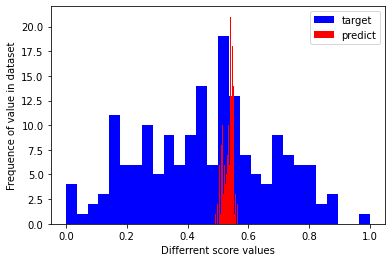

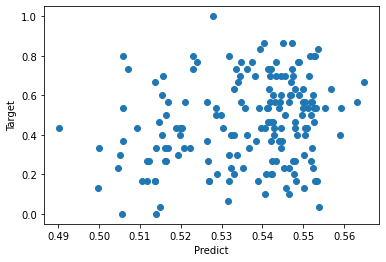

Epoch 1:   0%|          | 0/33 [00:00<?, ?batch/s]

  Validation took: 0:00:02

======== Epoch 1 / 3 ========
Training...


Epoch 1: 100%|██████████| 33/33 [00:16<00:00,  1.98batch/s, loss=0.0428]



  Average valid loss: 0.06
Report:
mean_squared_error: 0.0608999989926815
mean_absolute_error: 0.2020999938249588
r2_score -0.3288
pearsonr_corr: 0.1891, pearsonr_p: 0.0125
spearman_corr: 0.1481, spearman_p: 0.0511



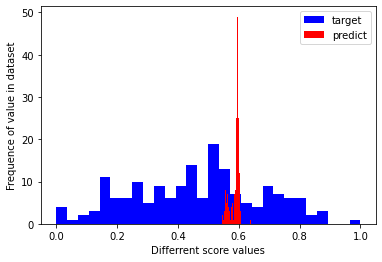

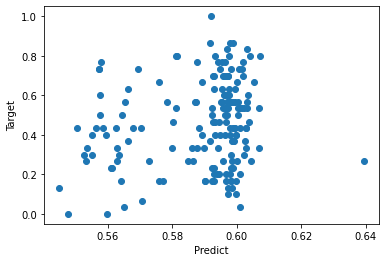

Epoch 2:   0%|          | 0/33 [00:00<?, ?batch/s]

  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...


Epoch 2: 100%|██████████| 33/33 [00:16<00:00,  1.98batch/s, loss=0.0377]



  Average valid loss: 0.04
Report:
mean_squared_error: 0.04410000145435333
mean_absolute_error: 0.17389999330043793
r2_score 0.0366
pearsonr_corr: 0.2384, pearsonr_p: 0.0015
spearman_corr: 0.199, spearman_p: 0.0085



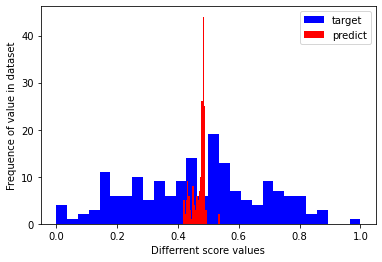

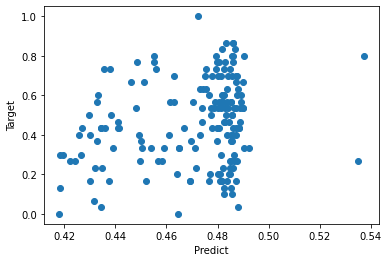

  Validation took: 0:00:02

Training complete!


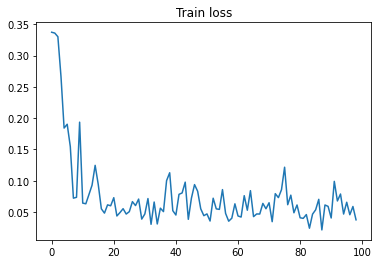

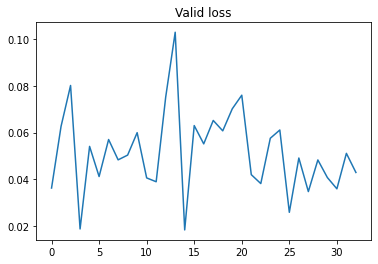

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_with_many_text.texts, data_with_many_text.diener_score)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)
train_texts = pd.DataFrame({"join_text": X_train_join.tolist(),  "diener_score": y_train.tolist()})
test_texts = pd.DataFrame({"join_text": X_test_join.tolist(),  "diener_score": y_test.tolist()})
m_mert = train_bert(
    train=train_texts,
    test=test_texts,
    target="diener_score",
    source="join_text",
    epochs=3,
    model_name_or_path="/home/ssorokin/sentence_ru_cased_L-12_H-768_A-12_pt/"
)

In [ ]:
# sentence_ru_cased_L-12_H-768_A-12_pt and who_score

100%|██████████| 174/174 [00:06<00:00, 25.75it/s]
Some weights of the model checkpoint at /home/ssorokin/sentence_ru_cased_L-12_H-768_A-12_pt/ were not used when initializing BertMSE: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertMSE from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertMSE from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertMSE were not initialized from the model checkpoint at /h


======== Epoch 0 / 3 ========
Training...


Epoch 0: 100%|██████████| 33/33 [00:16<00:00,  1.99batch/s, loss=0.033] 



  Average valid loss: 0.04
Report:
mean_squared_error: 0.03869999945163727
mean_absolute_error: 0.16030000150203705
r2_score 0.0048
pearsonr_corr: 0.0885, pearsonr_p: 0.2456
spearman_corr: 0.0937, spearman_p: 0.2187



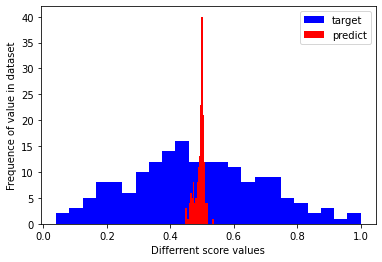

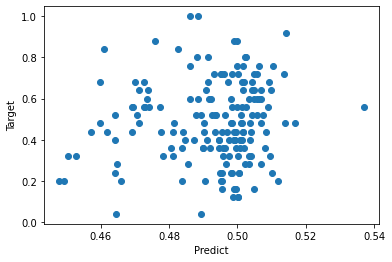

Epoch 1:   0%|          | 0/33 [00:00<?, ?batch/s]

  Validation took: 0:00:02

======== Epoch 1 / 3 ========
Training...


Epoch 1: 100%|██████████| 33/33 [00:16<00:00,  1.98batch/s, loss=0.0764]



  Average valid loss: 0.04
Report:
mean_squared_error: 0.040300000458955765
mean_absolute_error: 0.16329999268054962
r2_score -0.0356
pearsonr_corr: -0.0384, pearsonr_p: 0.6153
spearman_corr: -0.0029, spearman_p: 0.9699



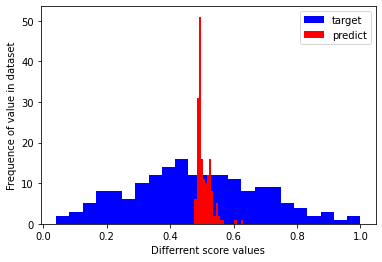

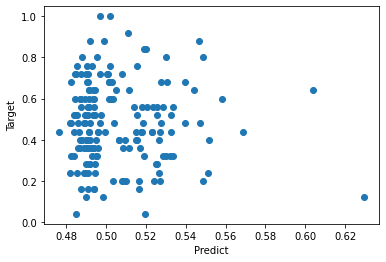

Epoch 2:   0%|          | 0/33 [00:00<?, ?batch/s]

  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...


Epoch 2: 100%|██████████| 33/33 [00:16<00:00,  1.98batch/s, loss=0.0184]



  Average valid loss: 0.04
Report:
mean_squared_error: 0.039000000804662704
mean_absolute_error: 0.16099999845027924
r2_score -0.0027
pearsonr_corr: 0.0147, pearsonr_p: 0.8477
spearman_corr: 0.1199, spearman_p: 0.1149



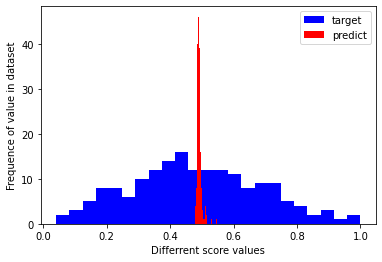

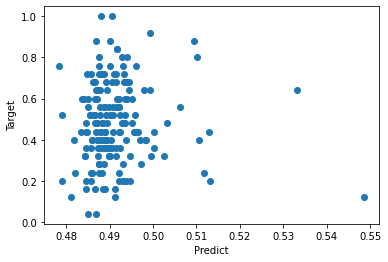

  Validation took: 0:00:02

Training complete!


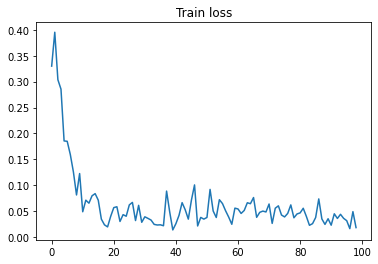

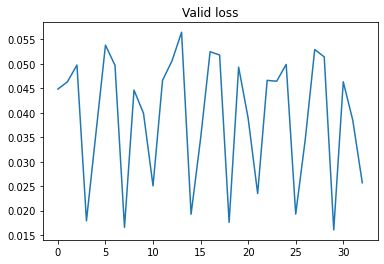

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_with_many_text.texts, data_with_many_text.who_score)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)
train_texts = pd.DataFrame({"join_text": X_train_join.tolist(),  "who_score": y_train.tolist()})
test_texts = pd.DataFrame({"join_text": X_test_join.tolist(),  "who_score": y_test.tolist()})
m_mert = train_bert(
    train=train_texts,
    test=test_texts,
    target="who_score",
    source="join_text",
    epochs=3,
    model_name_or_path="/home/ssorokin/sentence_ru_cased_L-12_H-768_A-12_pt/"
)

In [ ]:
# Проверим будут ли работать простые метода на данной выборке

In [51]:
from sklearn.model_selection import train_test_split
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize
from scripts.metrics import get_metrics, plot_two_distributions

In [ ]:
# TfidfVectorizer + TruncatedSVD - who_score

Report:
mean_squared_error: 0.0406
mean_absolute_error: 0.1637
r2_score 0.0111
pearsonr_corr: 0.2148, pearsonr_p: 0.0044
spearman_corr: 0.1579, spearman_p: 0.0374



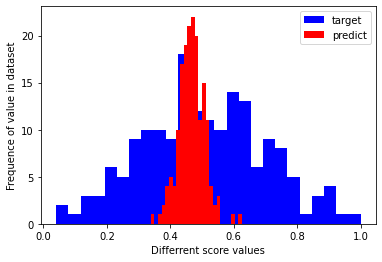

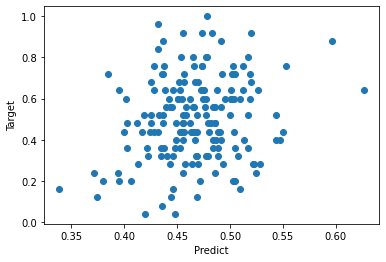

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    data_with_many_text.texts, data_with_many_text.who_score, random_state=0
)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)

pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize
            )
    ), 
    ('pca', TruncatedSVD(400)), 
    ('lr', Ridge())
])

pipe.fit(X_train_join, y_train)
predicted_y = pipe.predict(X_test_join)
get_metrics(y_test, predicted_y,)
plot_two_distributions(y_test, predicted_y)

In [8]:
# TfidfVectorizer + TruncatedSVD - diener_score

Report:
mean_squared_error: 0.0562
mean_absolute_error: 0.2003
r2_score 0.0187
pearsonr_corr: 0.156, pearsonr_p: 0.0399
spearman_corr: 0.1681, spearman_p: 0.0266



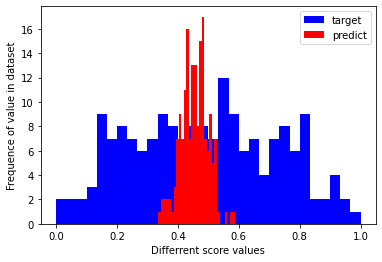

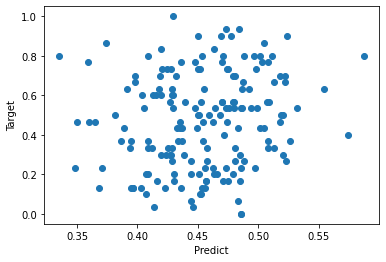

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    data_with_many_text.texts, data_with_many_text.diener_score, random_state=0
)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)

pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize
            )
    ), 
    ('pca', TruncatedSVD(400)), 
    ('lr', Ridge())
])

pipe.fit(X_train_join, y_train)
predicted_y = pipe.predict(X_test_join)
get_metrics(y_test, predicted_y,)
plot_two_distributions(y_test, predicted_y)

In [ ]:
# TfidfVectorizer - who_score

Report:
mean_squared_error: 0.0404
mean_absolute_error: 0.1632
r2_score 0.015
pearsonr_corr: 0.2242, pearsonr_p: 0.0029
spearman_corr: 0.1641, spearman_p: 0.0304



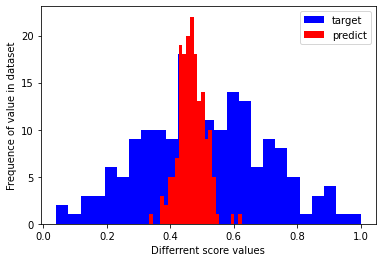

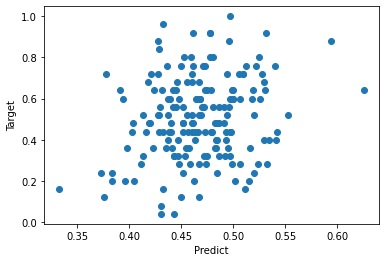

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    data_with_many_text.texts, data_with_many_text.who_score, random_state=0
)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)

pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize
            )
    ), 
    ('lr', Ridge())
])

pipe.fit(X_train_join, y_train)
predicted_y = pipe.predict(X_test_join)
get_metrics(y_test, predicted_y,)
plot_two_distributions(y_test, predicted_y)

In [ ]:
# TfidfVectorizer - diener_score

Report:
mean_squared_error: 0.0559
mean_absolute_error: 0.1995
r2_score 0.0245
pearsonr_corr: 0.1699, pearsonr_p: 0.025
spearman_corr: 0.193, spearman_p: 0.0107



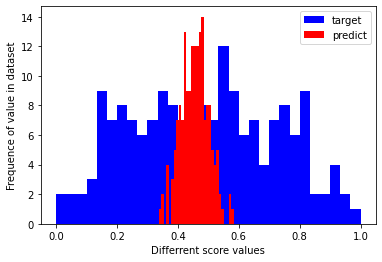

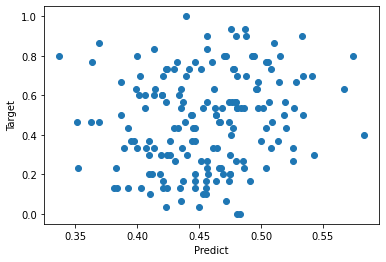

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    data_with_many_text.texts, data_with_many_text.diener_score, random_state=0
)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)

pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize
            )
    ), 
    ('lr', Ridge())
])

pipe.fit(X_train_join, y_train)
predicted_y = pipe.predict(X_test_join)
get_metrics(y_test, predicted_y,)
plot_two_distributions(y_test, predicted_y)

In [ ]:
# add stop words + TfidfVectorizer - who_score

In [61]:
stop_words = """
и
в
во
не
что
он
на
я
с
со
как
а
то
все
она
так
его
но
да
ты
к
у
же
вы
за
бы
по
только
ее
мне
было
вот
от
меня
еще
нет
о
из
ему
теперь
когда
даже
ну
вдруг
ли
если
уже
или
ни
быть
был
него
до
вас
нибудь
опять
уж
вам
сказал
ведь
там
потом
себя
ничего
ей
может
они
тут
где
есть
надо
ней
для
мы
тебя
их
чем
была
сам
чтоб
без
будто
человек
чего
раз
тоже
себе
под
жизнь
будет
ж
тогда
кто
этот
говорил
того
потому
этого
какой
совсем
ним
здесь
этом
один
почти
мой
тем
чтобы
нее
кажется
сейчас
были
куда
зачем
сказать
всех
никогда
сегодня
можно
при
наконец
два
об
другой
хоть
после
над
больше
тот
через
эти
нас
про
всего
них
какая
много
разве
сказала
три
эту
моя
впрочем
хорошо
свою
этой
перед
иногда
лучше
чуть
том
нельзя
такой
им
более
всегда
конечно
всю
между"""
stop_words = [i for i in stop_words.split("\n") if i.strip()]
stop_words[:3]

['и', 'в', 'во']

Report:
mean_squared_error: 0.0411
mean_absolute_error: 0.1644
r2_score -0.0015
pearsonr_corr: 0.1795, pearsonr_p: 0.0178
spearman_corr: 0.1474, spearman_p: 0.0523



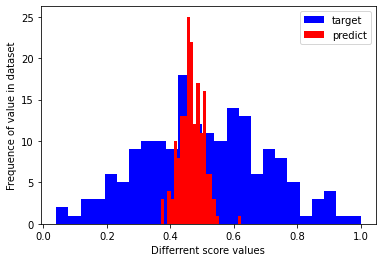

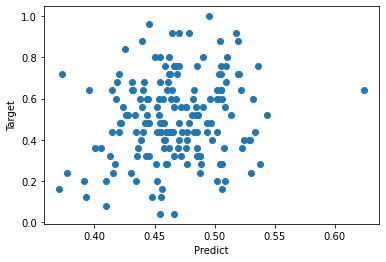

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    data_with_many_text.texts, data_with_many_text.who_score, random_state=0
)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)

pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize,
               stop_words=stop_words
            )
    ), 
    ('lr', Ridge())
])

pipe.fit(X_train_join, y_train)
predicted_y = pipe.predict(X_test_join)
get_metrics(y_test, predicted_y,)
plot_two_distributions(y_test, predicted_y)

In [ ]:
# add stop words + TfidfVectorizer - diener_score

Report:
mean_squared_error: 0.0566
mean_absolute_error: 0.2006
r2_score 0.0113
pearsonr_corr: 0.1288, pearsonr_p: 0.0902
spearman_corr: 0.1962, spearman_p: 0.0095



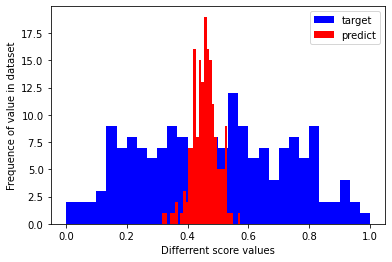

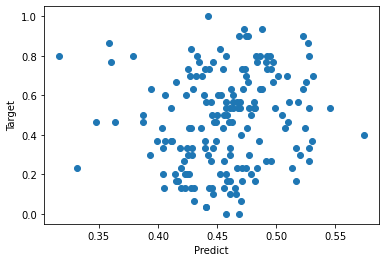

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    data_with_many_text.texts, data_with_many_text.diener_score, random_state=0
)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)

pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize,
               stop_words=stop_words
            )
    ), 
    ('lr', Ridge())
])

pipe.fit(X_train_join, y_train)
predicted_y = pipe.predict(X_test_join)
get_metrics(y_test, predicted_y,)
plot_two_distributions(y_test, predicted_y)

In [70]:
## feature selection 
# diener_score with feature selection using matrix correlation with target
# left only features that have correlation > quantile(0.5)

In [ ]:
# diener score

(521, 18692)
9364
Report:
mean_squared_error: 0.056
mean_absolute_error: 0.2016
r2_score 0.022
pearsonr_corr: 0.1933, pearsonr_p: 0.0106
spearman_corr: 0.2051, spearman_p: 0.0066



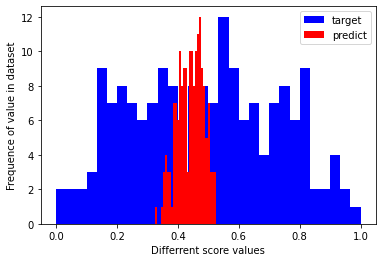

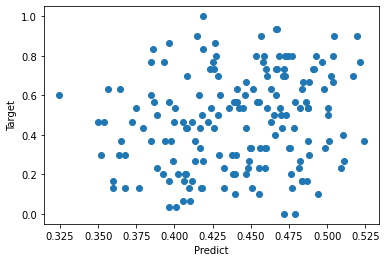

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(
    data_with_many_text.texts, data_with_many_text.diener_score, random_state=0
)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)

vectorizer = TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize,
            )

X_train_join_tf = vectorizer.fit_transform(X_train_join)
X_test_join_tf = vectorizer.transform(X_test_join)
print(X_train_join_tf.shape)

correlations = np.corrcoef(np.array(X_train_join_tf.todense().transpose()), y_train)
selected_feateres = []
quantile_08 = np.quantile(correlations[:,-1], 0.5)
quantile_02 = np.quantile(correlations[:,-1], 0.001)

for index, v in enumerate(correlations[:,-1].tolist()):
    if (v > quantile_08 and v < 1) or (v < quantile_02 and v < 1):
        selected_feateres.append(index)
print(len(selected_feateres))

rm = Ridge()
rm.fit(X_train_join_tf[:,selected_feateres] , y_train)
predicted_y = rm.predict(X_test_join_tf[:, selected_feateres])
get_metrics(y_test, predicted_y,)
plot_two_distributions(y_test, predicted_y)

In [ ]:
# who_score

(521, 18692)
9364
Report:
mean_squared_error: 0.0424
mean_absolute_error: 0.166
r2_score -0.032
pearsonr_corr: 0.1925, pearsonr_p: 0.0109
spearman_corr: 0.1657, spearman_p: 0.0289



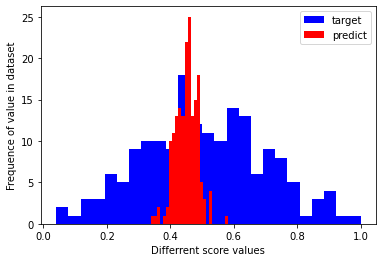

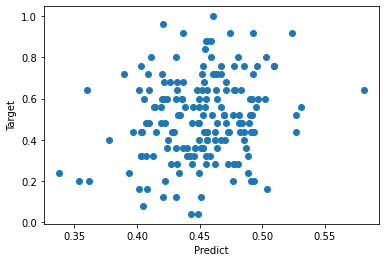

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(
    data_with_many_text.texts, data_with_many_text.who_score, random_state=0
)
X_train_join = X_train.apply(get_text)
X_test_join = X_test.apply(get_text)

vectorizer = TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize,
            )

X_train_join_tf = vectorizer.fit_transform(X_train_join)
X_test_join_tf = vectorizer.transform(X_test_join)
print(X_train_join_tf.shape)

correlations = np.corrcoef(np.array(X_train_join_tf.todense().transpose()), y_train)
selected_feateres = []
quantile_08 = np.quantile(correlations[:,-1], 0.5)
quantile_02 = np.quantile(correlations[:,-1], 0.001)

for index, v in enumerate(correlations[:,-1].tolist()):
    if (v > quantile_08 and v < 1) or (v < quantile_02 and v < 1):
        selected_feateres.append(index)
print(len(selected_feateres))

rm = Ridge()
rm.fit(X_train_join_tf[:,selected_feateres] , y_train)
predicted_y = rm.predict(X_test_join_tf[:, selected_feateres])
get_metrics(y_test, predicted_y,)
plot_two_distributions(y_test, predicted_y)